Curve cleaning, curve fitting and the exploration about the corrrelations between deviations and weather factors for each farm

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150
import datetime as dt
import numpy as np
from scipy import signal
import sklearn.linear_model as skl_lm
import time
import math
from scipy import stats
sns.set()

In [2]:
# Importing the milking data and cleaning it a bit
milk = pd.read_csv("AllMilkings.csv", usecols=["StartDate", "FarmName_Pseudo", "SE_Number", "SE_Number", "LactationNumber", "DaysInMilk", "TotalYield"])
milk = milk[milk["TotalYield"].notnull()]
milk = milk[milk["SE_Number"] != "Unknown"]
milk = milk.drop_duplicates()
milk["StartDate"] = pd.to_datetime(milk["StartDate"])
milk = milk.sort_values(["StartDate"])
milk = milk.groupby(["SE_Number","StartDate"]).agg({"TotalYield": "sum", "DaysInMilk": "first", "LactationNumber": "first", "FarmName_Pseudo": "first"})
milk = milk.reset_index()

In [3]:
# Original records for cow SE-a624fb9a-1312
cow_1312_before = milk[milk["SE_Number"] == "SE-a624fb9a-1312"]

In [4]:
cow_1312_before[cow_1312_before["LactationNumber"] == 1]

,SE_Number,StartDate,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo
407962,SE-a624fb9a-1312,2020-03-09,25.16,19.0,1.0,a624fb9a
407963,SE-a624fb9a-1312,2020-03-10,17.64,20.0,1.0,a624fb9a
407964,SE-a624fb9a-1312,2020-03-11,22.03,21.0,1.0,a624fb9a
407965,SE-a624fb9a-1312,2020-03-12,19.42,22.0,1.0,a624fb9a
407966,SE-a624fb9a-1312,2020-03-13,20.34,23.0,1.0,a624fb9a
...,...,...,...,...,...,...
408208,SE-a624fb9a-1312,2020-11-21,19.29,276.0,1.0,a624fb9a
408209,SE-a624fb9a-1312,2020-11-22,23.32,277.0,1.0,a624fb9a
408210,SE-a624fb9a-1312,2020-11-23,19.82,278.0,1.0,a624fb9a
408211,SE-a624fb9a-1312,2020-11-25,12.99,280.0,1.0,a624fb9a


In [5]:
cow_1312_before[cow_1312_before["LactationNumber"] == 2]

,SE_Number,StartDate,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo
408213,SE-a624fb9a-1312,2021-01-22,21.11,2.0,2.0,a624fb9a
408214,SE-a624fb9a-1312,2021-01-24,29.39,4.0,2.0,a624fb9a
408215,SE-a624fb9a-1312,2021-01-25,27.47,5.0,2.0,a624fb9a
408216,SE-a624fb9a-1312,2021-01-26,27.08,6.0,2.0,a624fb9a
408217,SE-a624fb9a-1312,2021-01-27,34.14,7.0,2.0,a624fb9a
...,...,...,...,...,...,...
408487,SE-a624fb9a-1312,2021-11-06,22.25,290.0,2.0,a624fb9a
408488,SE-a624fb9a-1312,2021-11-07,21.82,291.0,2.0,a624fb9a
408489,SE-a624fb9a-1312,2021-11-09,15.24,293.0,2.0,a624fb9a
408490,SE-a624fb9a-1312,2021-11-11,10.94,295.0,2.0,a624fb9a


In [6]:
cow_1312_before[cow_1312_before["LactationNumber"] == 3]

,SE_Number,StartDate,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo
408492,SE-a624fb9a-1312,2022-01-13,27.41,2.0,3.0,a624fb9a
408493,SE-a624fb9a-1312,2022-01-14,23.24,3.0,3.0,a624fb9a
408494,SE-a624fb9a-1312,2022-01-15,31.39,4.0,3.0,a624fb9a
408495,SE-a624fb9a-1312,2022-01-16,38.18,5.0,3.0,a624fb9a
408496,SE-a624fb9a-1312,2022-01-17,35.90,6.0,3.0,a624fb9a
...,...,...,...,...,...,...
408710,SE-a624fb9a-1312,2022-08-19,41.71,220.0,3.0,a624fb9a
408711,SE-a624fb9a-1312,2022-08-20,30.35,221.0,3.0,a624fb9a
408712,SE-a624fb9a-1312,2022-08-21,40.57,222.0,3.0,a624fb9a
408713,SE-a624fb9a-1312,2022-08-22,34.49,223.0,3.0,a624fb9a


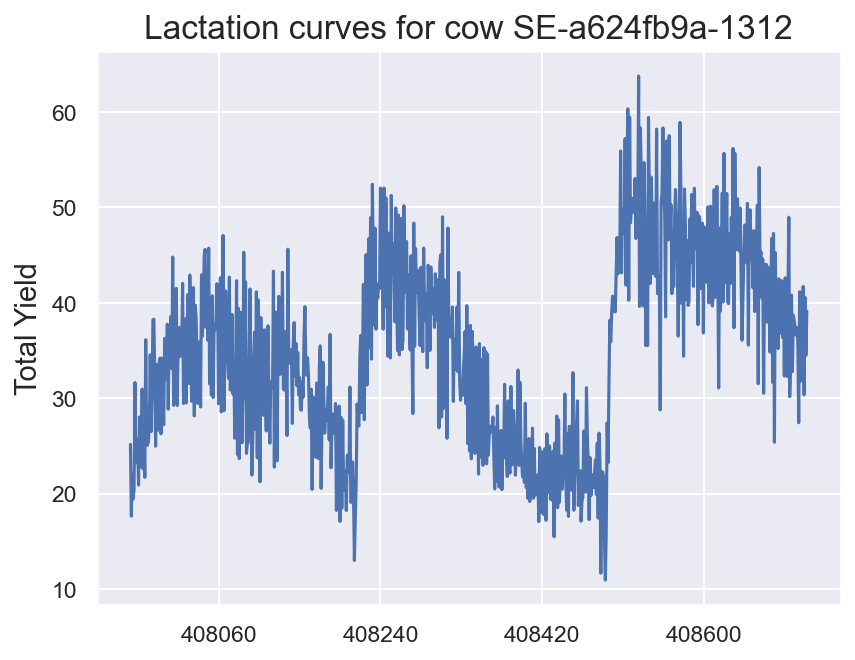

In [7]:
# Plot the lactation curves for cow SE-a624fb9a-1312
fig, ax = plt.subplots(1,1)
sns.lineplot(x = cow_1312_before.index, y = cow_1312_before["TotalYield"])
ax.set_ylabel("Total Yield", fontsize = 14)
tick_spacing = 180
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
plt.title("Lactation curves for cow SE-a624fb9a-1312",x = 0.5, y = 1, fontsize = 16)
plt.savefig("Lactation curve example", bbox_inches = 'tight')
plt.show()

In [8]:
# Filtering out all cows that could potentially be used
allCowNames = milk["SE_Number"].unique()
longCowNames = []
for name in allCowNames:
    cow = milk[milk["SE_Number"] == name]
    l = len(cow)
    LP = cow["LactationNumber"].count()/l
    DP = cow["DaysInMilk"].count()/l
    if LP == 1 and DP > 0.8 and l > 150:
        longCowNames.append(name)

In [9]:
# Remove outliers
def zDrop(curve1):
    yield_mean = curve1["TotalYield"].mean()
    curve = curve1.copy()
    # If the time inverval between two consecutive records in one lactation is more than 30 days, the latter one is regarded as wrong record and dropped.
    curve = curve.set_index(curve["StartDate"])
    differ = curve["StartDate"] - curve["StartDate"].shift(1, fill_value = curve["StartDate"].iloc[0])
    curve["differ_days"] = differ.dt.days
    curve = curve.drop(index = curve[curve["differ_days"] > 30].index)
    curve = curve.drop(["differ_days"], axis = 1)
    
    # Remove the records whose yields are too large
    curve.loc[curve["TotalYield"] > yield_mean * 2, "TotalYield"] = np.nan
    window = 14
    # Remove outliers using z-score
    roll = curve["TotalYield"].rolling(window)
    curve.loc[:, 'z-score'] = (curve.loc[:, "TotalYield"] - roll.mean()) / roll.std()
    curve.loc[:, "TotalYield"] = curve.loc[:, "TotalYield"].mask(abs(curve.loc[:, "z-score"])>2)
    curve = curve.drop("z-score", axis = 1)
    return curve

In [10]:
# Estimating the start of a lactaion curve using formulas made by Anna Edvardsson Rasmussen
def calcBeginning(firstLact):
    #Seting intercept as half of the mean instead of zero since that is close to the average of the complete curves in the data
    intercept = 0.5*firstLact["TotalYield"].mean()
    MYminDIMmedel = firstLact["TotalYield"].iloc[0:3].mean()
    minDIM = firstLact['DaysInMilk'].iloc[0]
    SE_Number = firstLact['SE_Number'].iloc[0]
    StartDate = firstLact['StartDate'].iloc[0] - dt.timedelta(days=1)
    DaysInMilk = firstLact['DaysInMilk'].iloc[0] - 1
    LactationNumber = firstLact['LactationNumber'].iloc[0]
    FarmName_Pseudo = firstLact['FarmName_Pseudo'].iloc[0]

    #Calculating the beginning of the curve and concatenating it with the incomplete curve
    while DaysInMilk > 0:
        x = (MYminDIMmedel-intercept)/(np.log(minDIM))
        MY = x * np.log(DaysInMilk) + intercept

        d = {"SE_Number": SE_Number, "StartDate": StartDate, "TotalYield": MY, "DaysInMilk": DaysInMilk, "LactationNumber": LactationNumber, "FarmName_Pseudo": FarmName_Pseudo}
        q = pd.DataFrame(d, index = [0])

        firstLact = pd.concat([q, firstLact], ignore_index=True)

        DaysInMilk = DaysInMilk - 1
        StartDate = StartDate - dt.timedelta(days=1)

    return firstLact

In [11]:
# Filling holes using a combination of rolling mean and linear interpolation
def interpolateMissing(curve):
    SE_Number = curve['SE_Number'].iloc[0]
    LactationNumber = curve['LactationNumber'].iloc[0]
    FarmName_Pseudo = curve['FarmName_Pseudo'].iloc[0]

    curve = curve.set_index("StartDate")

    firstDate = curve.index[0]
    lastDate = curve.index[-1]

    idx = pd.date_range(firstDate, lastDate)
    curve = curve.reindex(idx, fill_value= np.nan)

    curve['rollmean20'] = curve['TotalYield'].rolling(20,center=True,min_periods=1).mean()
    
    for index, row in curve.iterrows():
        if pd.isna(curve['SE_Number'].loc[index]):
            curve.loc[index, 'SE_Number'] = SE_Number
            curve.loc[index, 'FarmName_Pseudo'] = FarmName_Pseudo
            curve.loc[index, 'LactationNumber'] = LactationNumber
            nDays = (index - firstDate).days
            curve.loc[index, 'DaysInMilk'] = nDays + 1
            curve.loc[index, 'TotalYield'] = curve.loc[index, 'rollmean20']

    curve = curve.interpolate(method = "linear")

    return curve

In [12]:
# Apply zDrop, calcBeginning, interpolateMissing to every lactation of each cow
curves = []
for name in longCowNames:
    cow = milk[milk["SE_Number"] == name]
    lactations = cow["LactationNumber"].unique()
    lactations = [int(x) for x in lactations if str(x) != 'nan']
    for lactation in lactations:
        eachLact = cow[cow["LactationNumber"] == lactation]
        eachLact = zDrop(eachLact)
        firstDIM = eachLact['DaysInMilk'].iloc[0]
        lastDIM = eachLact['DaysInMilk'].iloc[-1]
        if firstDIM <= 60:
            eachLact = calcBeginning(eachLact)
            # Append to the set of good curves if not too long
            if len(eachLact) < 400:
                curves.append(interpolateMissing(eachLact))

In [13]:
# Adding weather data to all cows
milk = pd.concat(curves)
milk = milk.reset_index()
milk = milk.rename(columns={"index": "StartDate"})

weatherCols = ["Timestamp", "T_C_mean", "THI_mean", "THI_adj_mean", "r_sfc_mean"]
uniqueFarms = milk["FarmName_Pseudo"].unique()
df = pd.DataFrame()
for farm in uniqueFarms:
    tf = pd.read_csv(f"E:/Computational Science/project/TempGroup/weather data/weatherandthi/{farm}_weather_daily.csv", usecols=weatherCols)
    tf["FarmName_Pseudo"] = farm
    df = pd.concat([df, tf])

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
milk = pd.merge(milk, df,  how='left', left_on=['StartDate','FarmName_Pseudo'], right_on = ['Timestamp','FarmName_Pseudo'])


In [14]:
# the number of cows after cleaning
len(milk["SE_Number"].unique())

485

In [15]:
# the number of records after cleaning
milk.shape[0]

126831

In [16]:
# Replace the farms' names
rDict = {"a624fb9a": "Farm 1",
        "ab18b151": "Farm 2",
        "540275a1": "Farm 3",
        "5b581702": "Farm 4",
        "5c06d92d": "Farm 5",
        "a756bc39": "Farm 6",
        "ad0a39f5": "Farm 7",
        "752efd72": "Farm 8",
        "f454e660": "Farm 9"}
milk = milk.replace({"FarmName_Pseudo": rDict})

In [17]:
# the number of cows for every farm after cleaning
farms = milk["FarmName_Pseudo"].unique()
for farm in farms:
    farm_data = milk[milk["FarmName_Pseudo"] == farm]
    cows_number = len(farm_data["SE_Number"].unique())
    print(f"{farm}: {cows_number}")

Farm 1: 38
Farm 3: 3
Farm 5: 207
Farm 8: 139
Farm 7: 14
Farm 2: 20
Farm 9: 64


In [18]:
# Records for cow SE-a624fb9a-1312 after cleaning
cow_1312_after = milk[milk["SE_Number"] == "SE-a624fb9a-1312"]

In [19]:
cow_1312_after[cow_1312_after["LactationNumber"] == 1]

,StartDate,SE_Number,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo,rollmean20,Timestamp,r_sfc_mean,T_C_mean,THI_mean,THI_adj_mean
85512,2020-02-20,SE-a624fb9a-1312,15.854488,1.0,1.0,Farm 1,18.806956,2020-02-20,0.949446,-0.494875,30.374408,30.029145
85513,2020-02-21,SE-a624fb9a-1312,17.209387,2.0,1.0,Farm 1,18.964657,2020-02-21,0.808483,4.614833,38.544425,36.899895
85514,2020-02-22,SE-a624fb9a-1312,18.001952,3.0,1.0,Farm 1,19.110248,2020-02-22,0.784974,5.436542,39.764329,36.280729
85515,2020-02-23,SE-a624fb9a-1312,18.564285,4.0,1.0,Farm 1,19.245476,2020-02-23,0.588841,3.281042,33.514980,39.419991
85516,2020-02-24,SE-a624fb9a-1312,19.000466,5.0,1.0,Farm 1,19.371733,2020-02-24,0.606582,0.010875,26.767195,37.655971
...,...,...,...,...,...,...,...,...,...,...,...,...
85787,2020-11-21,SE-a624fb9a-1312,19.290000,276.0,1.0,Farm 1,22.031667,2020-11-21,0.951128,2.017500,34.945027,33.893745
85788,2020-11-22,SE-a624fb9a-1312,23.320000,277.0,1.0,Farm 1,22.171818,2020-11-22,0.783912,4.147125,37.341366,38.262091
85789,2020-11-23,SE-a624fb9a-1312,19.820000,278.0,1.0,Farm 1,22.356000,2020-11-23,0.628906,2.807250,32.814846,38.427631
85790,2020-11-24,SE-a624fb9a-1312,22.351111,279.0,1.0,Farm 1,22.351111,2020-11-24,0.926706,1.032708,32.768802,37.671646


In [20]:
cow_1312_after[cow_1312_after["LactationNumber"] == 2]

,StartDate,SE_Number,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo,rollmean20,Timestamp,r_sfc_mean,T_C_mean,THI_mean,THI_adj_mean
85792,2021-01-21,SE-a624fb9a-1312,15.413564,1.0,2.0,Farm 1,28.144840,2021-01-21,0.984770,1.077375,33.735309,33.674593
85793,2021-01-22,SE-a624fb9a-1312,21.110000,2.0,2.0,Farm 1,29.524356,2021-01-22,0.971460,1.278625,33.927792,31.812367
85794,2021-01-23,SE-a624fb9a-1312,29.362142,3.0,2.0,Farm 1,29.362142,2021-01-23,0.929682,1.503625,33.847648,32.861507
85795,2021-01-24,SE-a624fb9a-1312,29.390000,4.0,2.0,Farm 1,30.176964,2021-01-24,0.953019,-0.945667,29.605345,33.680409
85796,2021-01-25,SE-a624fb9a-1312,27.470000,5.0,2.0,Farm 1,30.176964,2021-01-25,0.906733,-2.373875,26.168275,26.992342
...,...,...,...,...,...,...,...,...,...,...,...,...
86082,2021-11-07,SE-a624fb9a-1312,21.820000,291.0,2.0,Farm 1,20.885833,2021-11-07,0.939324,1.373000,33.675688,33.833187
86083,2021-11-08,SE-a624fb9a-1312,20.763636,292.0,2.0,Farm 1,20.763636,2021-11-08,0.878433,-1.737958,27.074747,31.195887
86084,2021-11-09,SE-a624fb9a-1312,15.240000,293.0,2.0,Farm 1,20.483000,2021-11-09,0.990213,0.522833,32.807676,31.832530
86085,2021-11-10,SE-a624fb9a-1312,20.547778,294.0,2.0,Farm 1,20.547778,2021-11-10,0.938025,6.604000,43.389057,44.422152


In [21]:
cow_1312_after[cow_1312_after["LactationNumber"] == 3]

,StartDate,SE_Number,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo,rollmean20,Timestamp,r_sfc_mean,T_C_mean,THI_mean,THI_adj_mean
86087,2022-01-12,SE-a624fb9a-1312,22.128664,1.0,3.0,Farm 1,33.643866,2022-01-12,0.953221,1.230750,33.633452,33.730802
86088,2022-01-13,SE-a624fb9a-1312,27.410000,2.0,3.0,Farm 1,34.135333,2022-01-13,0.730633,5.904417,40.395113,41.316056
86089,2022-01-14,SE-a624fb9a-1312,23.240000,3.0,3.0,Farm 1,34.872389,2022-01-14,0.618227,2.431875,31.824219,34.368781
86090,2022-01-15,SE-a624fb9a-1312,31.390000,4.0,3.0,Farm 1,35.793743,2022-01-15,0.675392,-0.631667,26.098326,35.848266
86091,2022-01-16,SE-a624fb9a-1312,38.180000,5.0,3.0,Farm 1,36.311333,2022-01-16,0.796290,1.561000,32.329793,35.126965
...,...,...,...,...,...,...,...,...,...,...,...,...
86306,2022-08-19,SE-a624fb9a-1312,41.710000,220.0,3.0,Farm 1,36.550667,2022-08-19,0.869162,20.647167,70.421134,69.947630
86307,2022-08-20,SE-a624fb9a-1312,30.350000,221.0,3.0,Farm 1,36.437143,2022-08-20,0.913164,19.750417,68.027381,68.394362
86308,2022-08-21,SE-a624fb9a-1312,40.570000,222.0,3.0,Farm 1,36.366923,2022-08-21,0.765494,16.551125,62.947474,62.306753
86309,2022-08-22,SE-a624fb9a-1312,34.490000,223.0,3.0,Farm 1,36.347500,2022-08-22,0.740812,15.527125,60.997981,61.761915


In [22]:
# Set 0 as missing values in the lactation curves
def fill_curve(curve):
    starttime = curve["StartDate"].iloc[0]
    endtime = curve["StartDate"].iloc[-1]
    curve_time = pd.date_range(start = starttime, end = endtime)
    curvec = curve.copy()
    curvec = curvec.set_index(curve["StartDate"], drop = True)
    curvec = curvec.reindex(curve_time, fill_value = 0)
    return curvec

In [23]:
# The missing values in the original data set are set as 0
cow_1312_before = fill_curve(cow_1312_before)

In [24]:
# The yields in dry periods are set as 0
cow_1312_after = fill_curve(cow_1312_after)

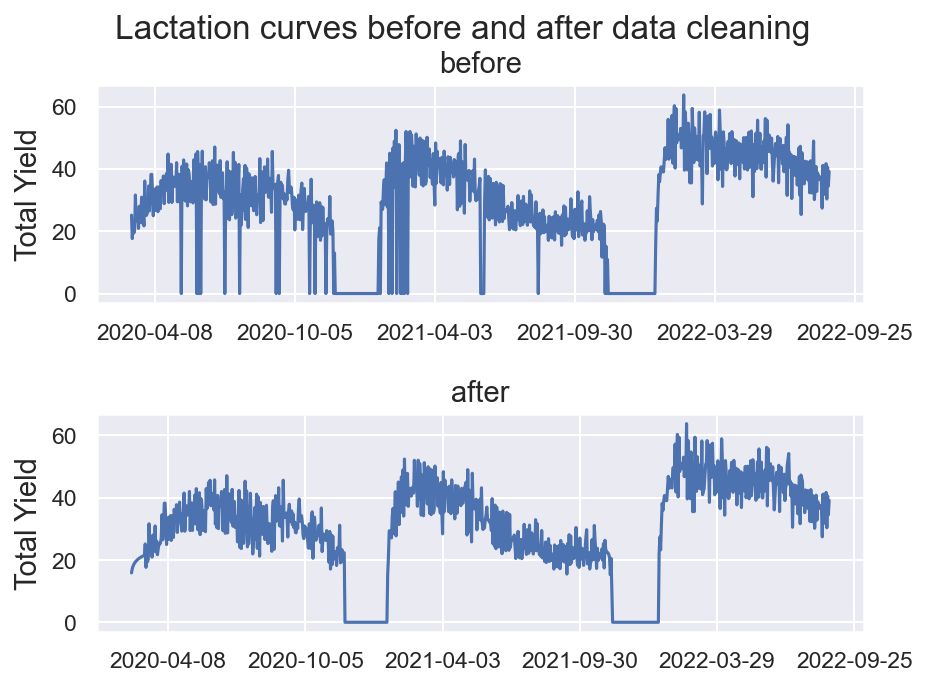

In [25]:
# Plot the lactation curves before and after data cleaning
fig, axs = plt.subplots(2,1)
fig.tight_layout(pad = 2.5)
axs = axs.ravel()
sns.lineplot(x = cow_1312_before.index, y = cow_1312_before["TotalYield"], ax = axs[0])
sns.lineplot(x = cow_1312_after.index, y = cow_1312_after["TotalYield"], ax = axs[1])
lst = ["before", "after"]
for i in range(2):
    axs[i].set_ylabel("Total Yield", fontsize = 14)
    axs[i].set_title(f"{lst[i]}", fontsize = 14)
    tick_spacing = 180
    axs[i].xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
plt.suptitle("Lactation curves before and after data cleaning",x = 0.5, y = 1, fontsize = 16)
plt.savefig("before and after data cleaning", bbox_inches = 'tight')
plt.show()

In [26]:
# Replace the weather factors' names
milk = milk.rename(columns = {"T_C_mean":"Temperature",
                              "THI_mean": "THI",
                              "THI_adj_mean": "THI_adj",
                              "r_sfc_mean": "Relative humidity"})

In [27]:
milk

,StartDate,SE_Number,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo,rollmean20,Timestamp,Relative humidity,Temperature,THI,THI_adj
0,2019-11-27,SE-064c0cec-1179,19.189937,1.0,5.0,Farm 1,31.456242,2019-11-27,0.985456,0.554000,32.796070,34.059469
1,2019-11-28,SE-064c0cec-1179,11.740000,2.0,5.0,Farm 1,32.243326,2019-11-28,0.964386,-0.698917,30.199881,29.196953
2,2019-11-29,SE-064c0cec-1179,25.920000,3.0,5.0,Farm 1,31.962994,2019-11-29,0.889705,-3.386292,23.958077,25.567343
3,2019-11-30,SE-064c0cec-1179,37.410000,4.0,5.0,Farm 1,32.899085,2019-11-30,0.841099,-4.050417,21.826228,25.287756
4,2019-12-01,SE-064c0cec-1179,34.005828,5.0,5.0,Farm 1,34.005828,2019-12-01,0.844470,-5.037458,19.950748,26.549373
...,...,...,...,...,...,...,...,...,...,...,...,...
126826,2022-08-19,SE-f454e660-686,18.140000,179.0,1.0,Farm 9,19.287143,2022-08-19,0.773764,23.855208,77.637745,71.985035
126827,2022-08-20,SE-f454e660-686,19.880000,180.0,1.0,Farm 9,19.506923,2022-08-20,0.891669,21.952500,72.418048,68.082749
126828,2022-08-21,SE-f454e660-686,18.350000,181.0,1.0,Farm 9,19.365000,2022-08-21,0.795920,18.370458,65.997363,63.825121
126829,2022-08-22,SE-f454e660-686,26.390000,182.0,1.0,Farm 9,19.197273,2022-08-22,0.705045,18.298375,66.268228,63.972419


In [28]:
# Wilmink lactation curve
def wilmink_lactation(t, y):
    t = np.array(t)
    x1 = t
    x2 = np.array(list(map(lambda x: math.exp(-0.05*x),t)))
    x = np.array([x1.T, x2.T]).T
    model = skl_lm.LinearRegression(fit_intercept = True)
    model.fit(x,y)
    prediction = model.predict(x)
    return prediction

In [29]:
# apply the wilmink model to every cow
farms = milk["FarmName_Pseudo"].unique()
for farm in farms:
    cows = milk[milk["FarmName_Pseudo"] == farm]["SE_Number"].unique()
    for cow in cows:
        data_cow = milk[milk["SE_Number"] == cow]
        lactations = data_cow["LactationNumber"].unique()
        for lactation in lactations:
            cow_lac = data_cow[data_cow["LactationNumber"] == lactation]
            cow_lac1 = cow_lac.copy()
            yield_wilmink = wilmink_lactation(cow_lac1["DaysInMilk"].tolist(), cow_lac1["TotalYield"].tolist())
            # Compute the Deviation
            cow_lac1["Deviation"] = cow_lac1["TotalYield"] - yield_wilmink
            cow_lac1["Yield_Wilmink"] = yield_wilmink
            milk.loc[cow_lac1.index, "Deviation"] = cow_lac1["Deviation"]
            milk.loc[cow_lac1.index, "Yield_Wilmink"] = cow_lac1["Yield_Wilmink"]

In [30]:
milk

,StartDate,SE_Number,TotalYield,DaysInMilk,LactationNumber,FarmName_Pseudo,rollmean20,Timestamp,Relative humidity,Temperature,THI,THI_adj,Deviation,Yield_Wilmink
0,2019-11-27,SE-064c0cec-1179,19.189937,1.0,5.0,Farm 1,31.456242,2019-11-27,0.985456,0.554000,32.796070,34.059469,-8.322754,27.512691
1,2019-11-28,SE-064c0cec-1179,11.740000,2.0,5.0,Farm 1,32.243326,2019-11-28,0.964386,-0.698917,30.199881,29.196953,-16.866707,28.606707
2,2019-11-29,SE-064c0cec-1179,25.920000,3.0,5.0,Farm 1,31.962994,2019-11-29,0.889705,-3.386292,23.958077,25.567343,-3.723628,29.643628
3,2019-11-30,SE-064c0cec-1179,37.410000,4.0,5.0,Farm 1,32.899085,2019-11-30,0.841099,-4.050417,21.826228,25.287756,6.783762,30.626238
4,2019-12-01,SE-064c0cec-1179,34.005828,5.0,5.0,Farm 1,34.005828,2019-12-01,0.844470,-5.037458,19.950748,26.549373,2.448643,31.557185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126826,2022-08-19,SE-f454e660-686,18.140000,179.0,1.0,Farm 9,19.287143,2022-08-19,0.773764,23.855208,77.637745,71.985035,-0.029528,18.169528
126827,2022-08-20,SE-f454e660-686,19.880000,180.0,1.0,Farm 9,19.506923,2022-08-20,0.891669,21.952500,72.418048,68.082749,1.754399,18.125601
126828,2022-08-21,SE-f454e660-686,18.350000,181.0,1.0,Farm 9,19.365000,2022-08-21,0.795920,18.370458,65.997363,63.825121,0.268328,18.081672
126829,2022-08-22,SE-f454e660-686,26.390000,182.0,1.0,Farm 9,19.197273,2022-08-22,0.705045,18.298375,66.268228,63.972419,8.352258,18.037742


In [31]:
# Records for cow SE-a624fb9a-1312 after applying wilmink model
cow_1312_wilmink = milk[milk["SE_Number"] == "SE-a624fb9a-1312"]
cow_1312_wilmink = fill_curve(cow_1312_wilmink)

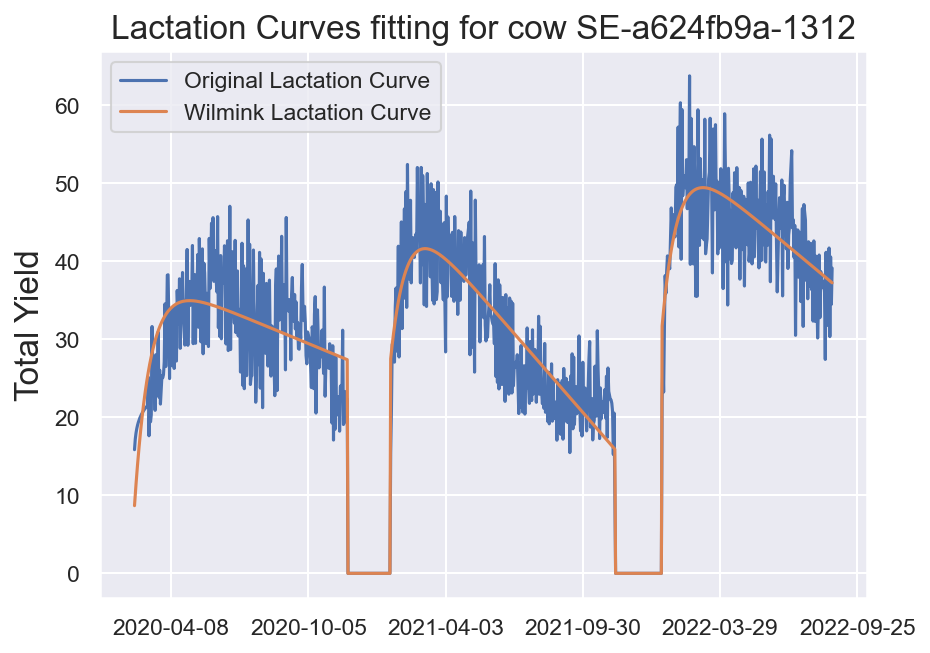

In [32]:
# Plot the lactation curves without and with wilmink model
fig, axs = plt.subplots(1,1)
fig.tight_layout(pad = 2.5)
sns.lineplot(x = cow_1312_wilmink.index, y = cow_1312_wilmink["TotalYield"], ax = axs, label = "Original Lactation Curve")
sns.lineplot(x = cow_1312_wilmink.index, y = cow_1312_wilmink["Yield_Wilmink"], ax = axs, label = "Wilmink Lactation Curve")
axs.set_ylabel("Total Yield", fontsize = 16)
axs.set_title(f"Lactation Curves fitting for cow SE-a624fb9a-1312", fontsize = 16)
tick_spacing = 180
axs.xaxis.set_major_locator(mpl.ticker.MultipleLocator(tick_spacing))
plt.savefig("With Wilmink", bbox_inches = 'tight')
plt.show()

In [33]:
# research the records period for every farm
for farm in farms:
    farm_data = milk[milk["FarmName_Pseudo"] == farm]
    farm_data = farm_data.sort_values("Timestamp")
    print(farm)
    start_date = farm_data.head(1)["Timestamp"].values
    print(f"start date: {start_date}")
    end_date = farm_data.tail(1)["Timestamp"].values
    print(f"end date: {end_date}")
    print("\n")

Farm 1
start date: ['2019-11-27T00:00:00.000000000']
end date: ['2022-08-23T00:00:00.000000000']


Farm 3
start date: ['2020-01-25T00:00:00.000000000']
end date: ['2021-04-23T00:00:00.000000000']


Farm 5
start date: ['2021-03-26T00:00:00.000000000']
end date: ['2022-06-23T00:00:00.000000000']


Farm 8
start date: ['2020-09-28T00:00:00.000000000']
end date: ['2022-08-23T00:00:00.000000000']


Farm 7
start date: ['2021-04-23T00:00:00.000000000']
end date: ['2022-06-05T00:00:00.000000000']


Farm 2
start date: ['2020-02-01T00:00:00.000000000']
end date: ['2022-07-26T00:00:00.000000000']


Farm 9
start date: ['2020-03-10T00:00:00.000000000']
end date: ['2022-08-23T00:00:00.000000000']




Farm 1
The correlation between Deviation and Temperature during the whole time period is 
Pearson: 0.0006126312433972768 
Kendall: -0.005794205794205793 
Spearman: -0.006782391261433177 

The correlation between Deviation and Temperature during summer time is 
Pearson: -0.28013178262573973 
Kendall: -0.17284364693387 
Spearman: -0.25584163057566267 

The correlation between Deviation and THI during the whole time period is 
Pearson: -0.0081410103413915 
Kendall: -0.011400599400599398 
Spearman: -0.015602971878420979 

The correlation between Deviation and THI during summer time is 
Pearson: -0.2712881658277106 
Kendall: -0.17111073844261837 
Spearman: -0.2535461866142326 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: 0.009119809406366688 
Kendall: 0.0010029970029970029 
Spearman: 0.00435450776768142 

The correlation between Deviation and THI_adj during summer time is 
Pearson: -0.255072536922866 
Kendall: -0.16328470009503046 
Spearman: -0.24

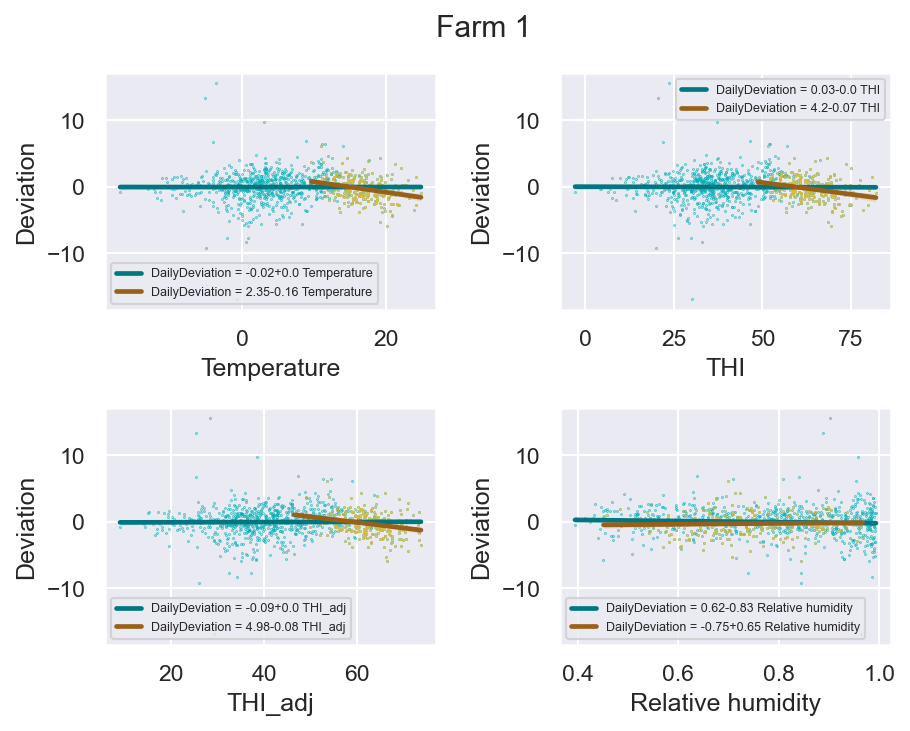

Farm 2
The correlation between Deviation and Temperature during the whole time period is 
Pearson: -0.126903233386489 
Kendall: -0.09369862280214449 
Spearman: -0.14567641936200346 

The correlation between Deviation and Temperature during summer time is 
Pearson: -0.06481791264027228 
Kendall: -0.029637377963737797 
Spearman: -0.04331325196617996 

The correlation between Deviation and THI during the whole time period is 
Pearson: -0.12922022480826767 
Kendall: -0.09566262890298903 
Spearman: -0.14822588613378412 

The correlation between Deviation and THI during summer time is 
Pearson: -0.05869048077120537 
Kendall: -0.025871687587168762 
Spearman: -0.038882619489921694 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: -0.12824517437767302 
Kendall: -0.0914520615959754 
Spearman: -0.14135492348333134 

The correlation between Deviation and THI_adj during summer time is 
Pearson: -0.04654297223228278 
Kendall: -0.013528591352859137 
Spearman: -

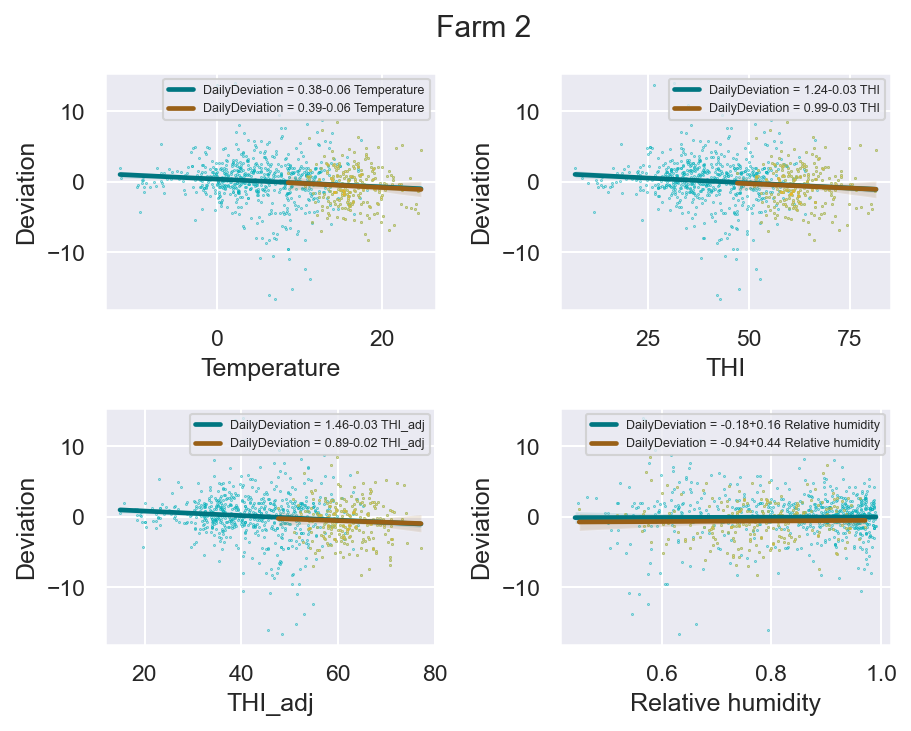

Farm 3
The correlation between Deviation and Temperature during the whole time period is 
Pearson: 0.1321776213059097 
Kendall: 0.08031175872585564 
Spearman: 0.1227956370084819 

The correlation between Deviation and Temperature during summer time is 
Pearson: 0.013149113743113944 
Kendall: 0.029144768275203056 
Spearman: 0.041474654377880185 

The correlation between Deviation and THI during the whole time period is 
Pearson: 0.14967729443941305 
Kendall: 0.09220119087960497 
Spearman: 0.14010059034404038 

The correlation between Deviation and THI during summer time is 
Pearson: 0.010910863466834415 
Kendall: 0.033444816053511704 
Spearman: 0.051169027326110075 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: 0.08222959953901768 
Kendall: 0.04170015007019412 
Spearman: 0.06392608087484045 

The correlation between Deviation and THI_adj during summer time is 
Pearson: 0.033087099119257536 
Kendall: 0.050645007166746296 
Spearman: 0.07106638102

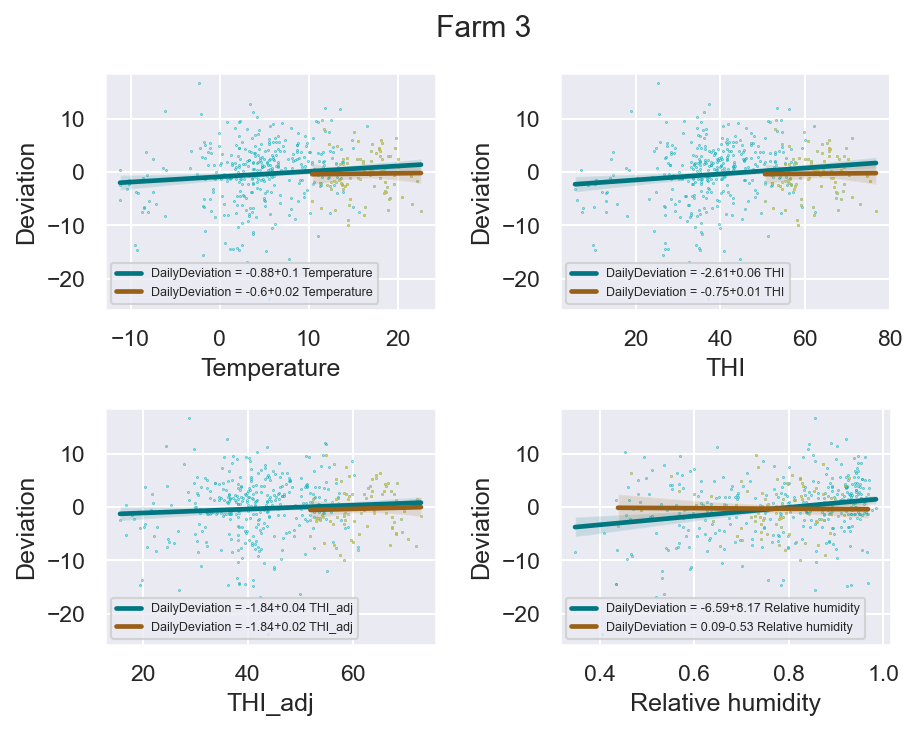

Farm 5
The correlation between Deviation and Temperature during the whole time period is 
Pearson: -0.5030594551208588 
Kendall: -0.45734617805102384 
Spearman: -0.6809396840117917 

The correlation between Deviation and Temperature during summer time is 
Pearson: 0.11579399896121575 
Kendall: 0.028832951945080097 
Spearman: 0.07956285015387045 

The correlation between Deviation and THI during the whole time period is 
Pearson: -0.4984775681992616 
Kendall: -0.4551967855932614 
Spearman: -0.6763434339831279 

The correlation between Deviation and THI during summer time is 
Pearson: 0.12475574241636096 
Kendall: 0.035240274599542334 
Spearman: 0.09090191746232149 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: -0.4824709621450547 
Kendall: -0.4469671297865131 
Spearman: -0.6666902770311072 

The correlation between Deviation and THI_adj during summer time is 
Pearson: 0.1903202009031592 
Kendall: 0.06086956521739131 
Spearman: 0.115197664325731

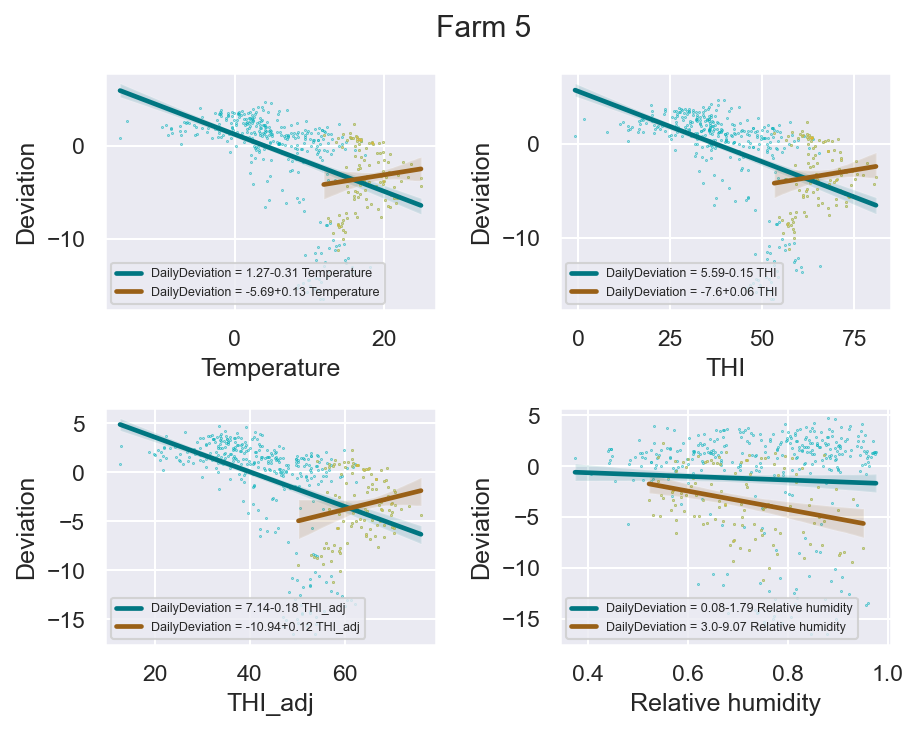

Farm 7
The correlation between Deviation and Temperature during the whole time period is 
Pearson: -0.45111265664303457 
Kendall: -0.37812441946852954 
Spearman: -0.5827275199127737 

The correlation between Deviation and Temperature during summer time is 
Pearson: -0.12960150688092525 
Kendall: -0.011813983528558699 
Spearman: -0.018744801785821445 

The correlation between Deviation and THI during the whole time period is 
Pearson: -0.44169231529999586 
Kendall: -0.36779308568356417 
Spearman: -0.5745408445617814 

The correlation between Deviation and THI during summer time is 
Pearson: -0.12107451283505859 
Kendall: -0.012243582929597197 
Spearman: -0.02164429585370894 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: -0.4518569033579955 
Kendall: -0.39034943160387137 
Spearman: -0.5891750792417684 

The correlation between Deviation and THI_adj during summer time is 
Pearson: -0.12006878606769485 
Kendall: -0.022983567955559652 
Spearman: -0

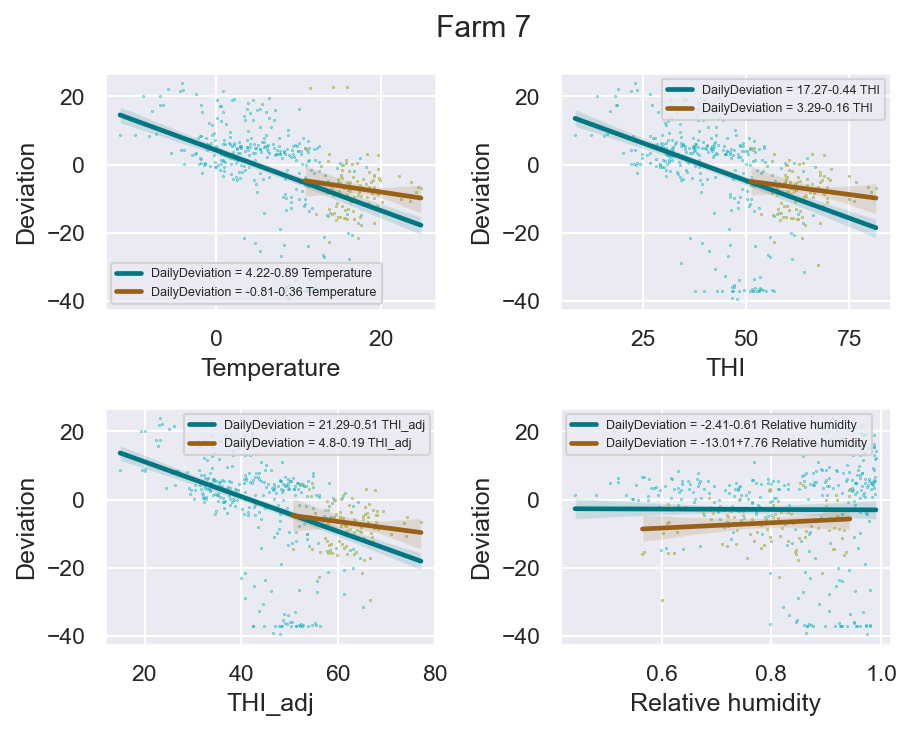

Farm 8
The correlation between Deviation and Temperature during the whole time period is 
Pearson: 0.11639084596098569 
Kendall: 0.08411253705968942 
Spearman: 0.11410731099111567 

The correlation between Deviation and Temperature during summer time is 
Pearson: -0.3536614481586053 
Kendall: -0.2438961038961039 
Spearman: -0.3618842174774378 

The correlation between Deviation and THI during the whole time period is 
Pearson: 0.11224812382608754 
Kendall: 0.0834490908713951 
Spearman: 0.11426327088979714 

The correlation between Deviation and THI during summer time is 
Pearson: -0.33489436415712937 
Kendall: -0.23207792207792208 
Spearman: -0.3461831388950033 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: 0.11345540069923905 
Kendall: 0.08536479174009495 
Spearman: 0.1122969179063983 

The correlation between Deviation and THI_adj during summer time is 
Pearson: -0.35147257971909523 
Kendall: -0.24597402597402596 
Spearman: -0.35428351309707

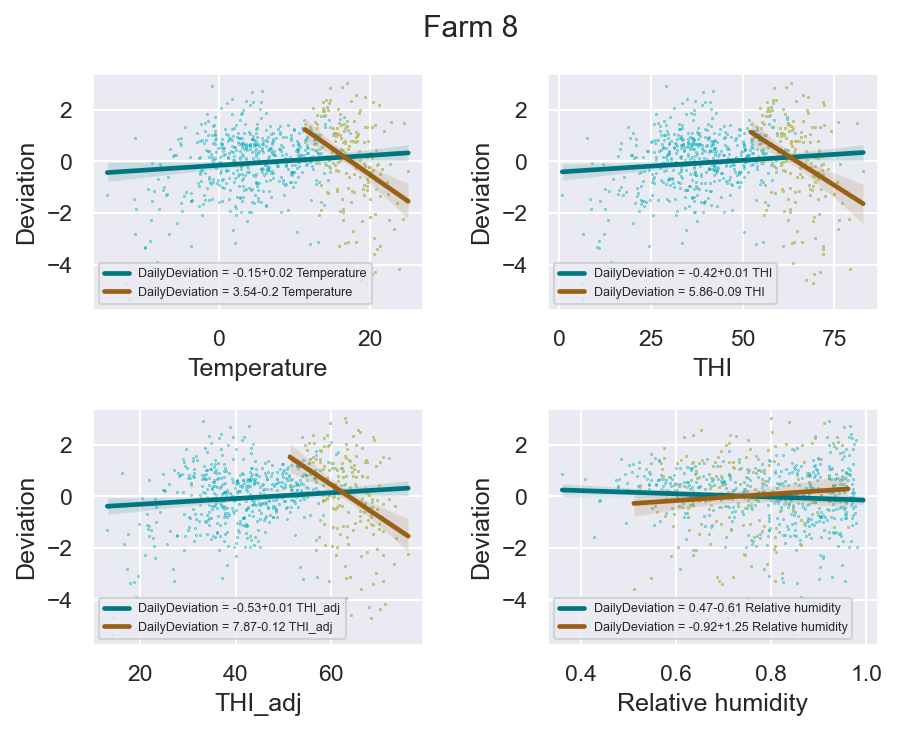

Farm 9
The correlation between Deviation and Temperature during the whole time period is 
Pearson: 0.011277822711339758 
Kendall: 0.002279429147336318 
Spearman: 0.0027688590871168942 

The correlation between Deviation and Temperature during summer time is 
Pearson: -0.16562925281507165 
Kendall: -0.14168122424694313 
Spearman: -0.22216029551508043 

The correlation between Deviation and THI during the whole time period is 
Pearson: 0.011186651134951937 
Kendall: 0.001562748845357541 
Spearman: 0.001966598812246144 

The correlation between Deviation and THI during summer time is 
Pearson: -0.14781152264312777 
Kendall: -0.1301917379395159 
Spearman: -0.20507628517119508 

The correlation between Deviation and THI_adj during the whole time period is 
Pearson: 0.030320988383023807 
Kendall: 0.020186335403726708 
Spearman: 0.030736935186436488 

The correlation between Deviation and THI_adj during summer time is 
Pearson: -0.1315331521199534 
Kendall: -0.11644027055732573 
Spearman: -0.

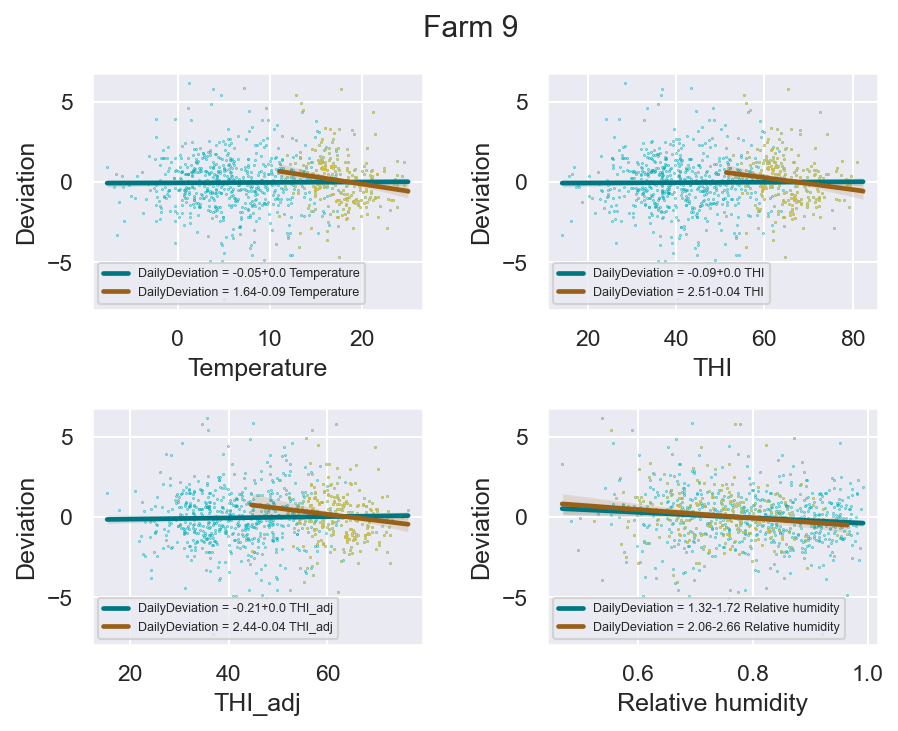

In [34]:
# Compute the correlations between deviations and temperatures for every farm during the whole record period
farms = ['Farm 1', 'Farm 2', 'Farm 3', 'Farm 5', 'Farm 7', 'Farm 8', 'Farm 9']
weathers = ["Temperature", "THI", "THI_adj", "Relative humidity"]
for farm in farms:
    print(f"{farm}")
    o = 1
    farm_data = milk[milk["FarmName_Pseudo"] == farm]
    summer = farm_data[((farm_data["Timestamp"] >= "2020-6-1") & (farm_data["Timestamp"] <= "2020-8-31")) | ((farm_data["Timestamp"] >= "2021-6-1") & (farm_data["Timestamp"] <= "2021-8-31")) | ((farm_data["Timestamp"] >= "2022-6-1") & (farm_data["Timestamp"] <= "2022-8-31"))]
    avgDeviation = farm_data.groupby(["Timestamp"]).agg({'Deviation': 'mean',"Temperature": "first","Relative humidity":"first", "THI":"first","THI_adj":"first"})
    avgDeviation_summer = summer.groupby(["Timestamp"]).agg({'Deviation': 'mean',"Temperature": "first","Relative humidity":"first", "THI":"first","THI_adj":"first"})

    fig, axs = plt.subplots(2, 2)
    fig.tight_layout(pad = 2)
    axs = axs.ravel()
    for i, weather in enumerate(weathers):
        slope, intercept, r_value, p_value, std_err = stats.linregress(avgDeviation[weather], avgDeviation['Deviation'])
        sSlope, sIntercept, sR_value, sP_value, sStd_err = stats.linregress(avgDeviation_summer[weather], avgDeviation_summer['Deviation'])

        if slope > 0:
            lab = f"DailyDeviation = {round(intercept, 2)}+{round(slope, 2)} {weather}"
        else:
            lab = f"DailyDeviation = {round(intercept, 2)}-{round(abs(slope), 2)} {weather}"
        if sSlope > 0:
            sLab = f"DailyDeviation = {round(sIntercept, 2)}+{round(sSlope, 2)} {weather}"
        else:
            sLab = f"DailyDeviation = {round(sIntercept, 2)}-{round(abs(sSlope), 2)} {weather}"
        
        pearson = avgDeviation["Deviation"].corr(avgDeviation[weather], method = "pearson")
        kendall = avgDeviation["Deviation"].corr(avgDeviation[weather], method = "kendall")
        spearman = avgDeviation["Deviation"].corr(avgDeviation[weather], method = "spearman")
        print(f"The correlation between Deviation and {weather} during the whole time period is \nPearson: {pearson} \nKendall: {kendall} \nSpearman: {spearman} \n")
        pearson_summer = avgDeviation_summer["Deviation"].corr(avgDeviation_summer[weather], method = "pearson")
        kendall_summer = avgDeviation_summer["Deviation"].corr(avgDeviation_summer[weather], method = "kendall")
        spearman_summer = avgDeviation_summer["Deviation"].corr(avgDeviation_summer[weather], method = "spearman")
        print(f"The correlation between Deviation and {weather} during summer time is \nPearson: {pearson_summer} \nKendall: {kendall_summer} \nSpearman: {spearman_summer} \n")
        sns.regplot(x = avgDeviation[weather], y = avgDeviation["Deviation"], ax=axs[i], color = "#00b0b9", order = o, line_kws={"color": "#007681", "label": lab}, scatter_kws={'s': 0.1})
        sns.regplot(x = avgDeviation_summer[weather], y = avgDeviation_summer["Deviation"],ax=axs[i], color = "#ffb81c", order = o, line_kws={"color": "#996017", "label": sLab}, scatter_kws={'s': 0.1})
        axs[i].legend(fontsize = 6)
            
    fig.suptitle(farm, x = 0.5, y = 1)
    plt.savefig(f"correlations for {farm} new.png", bbox_inches = 'tight')
    
    plt.show()
    # Blue dots represent the records during the whole time while yellow dots represent the records during summer time.